In [1]:
# notebook last tested with abtem version 1.0.0beta10

from abtem import __version__
print('current version:', __version__)

current version: 1.0.0beta10


In [6]:
import numpy as np
import matplotlib.pyplot as plt

from ase.calculators.lammpslib import LAMMPSlib
from ase.lattice.hexagonal import Graphene
from ase.md.velocitydistribution import (MaxwellBoltzmannDistribution, Stationary, ZeroRotation)
from ase.md.verlet import VelocityVerlet
from ase import units
from ase.io.trajectory import Trajectory

from abtem import *
from abtem.structures import orthogonalize_cell
from abtem.temperature import MDFrozenPhonons

# Simulation of thermal diffuse scattering with MD using LAMMPS

Create the atomic structure using ASE.

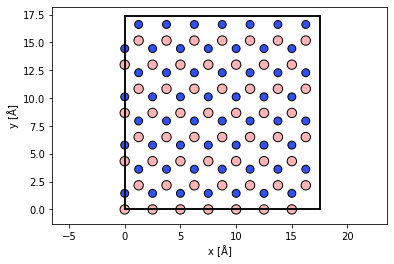

In [7]:
atoms = Graphene(symbol='N', latticeconstant={'a':2.502, 'c': 12})

atoms[0].symbol = 'B'

atoms = orthogonalize_cell(atoms)

repetitions = (7,4,1)

atoms *= repetitions

atoms.center(axis=2)

show_atoms(atoms);

Create a LAMMPS calculator for a tersoff potential.

In [8]:
cmds = ['pair_style tersoff',
        'pair_coeff * * BNC.tersoff B N']

lammps = LAMMPSlib(lmpcmds=cmds, log_file=None, keep_alive=True)

atoms.set_calculator(lammps)

In [9]:
def printenergy(a=atoms):  # store a reference to atoms in the definition.
    """Function to print the potential, kinetic and total energy."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print(f'Energy per atom: Epot = {epot:.3f} eV  Ekin = {ekin:.3f} eV (T = {ekin / (1.5 * units.kB):.3f} K) '
          f'Etot = {epot + ekin:.3f}eV')

We set up the molecular dynamics simulation, here just using the velocity Verlet algorithm.

In [10]:
# Set the momenta corresponding to T=1000K (the temperature will drop)

loginterval = 100
timestep = .1 * units.fs

MaxwellBoltzmannDistribution(atoms, 1000 * units.kB)
Stationary(atoms)  # zero linear momentum
ZeroRotation(atoms)  # zero angular momentum

# We want to run MD using the VelocityVerlet algorithm and save the trajectory file.
dyn = VelocityVerlet(atoms, timestep, trajectory='hbn.traj', loginterval=loginterval)
dyn.attach(printenergy, interval=1000)

# Now run the dynamics for 10000 timesteps.
dyn.run(10000)

Energy per atom: Epot = -7.507 eV  Ekin = 0.116 eV (T = 896.486 K) Etot = -7.391eV
Energy per atom: Epot = -7.438 eV  Ekin = 0.048 eV (T = 368.085 K) Etot = -7.391eV
Energy per atom: Epot = -7.450 eV  Ekin = 0.059 eV (T = 456.349 K) Etot = -7.391eV
Energy per atom: Epot = -7.450 eV  Ekin = 0.059 eV (T = 457.202 K) Etot = -7.391eV
Energy per atom: Epot = -7.445 eV  Ekin = 0.054 eV (T = 420.559 K) Etot = -7.391eV
Energy per atom: Epot = -7.444 eV  Ekin = 0.053 eV (T = 413.223 K) Etot = -7.391eV
Energy per atom: Epot = -7.450 eV  Ekin = 0.059 eV (T = 457.599 K) Etot = -7.391eV
Energy per atom: Epot = -7.451 eV  Ekin = 0.060 eV (T = 462.497 K) Etot = -7.391eV
Energy per atom: Epot = -7.451 eV  Ekin = 0.060 eV (T = 462.731 K) Etot = -7.391eV
Energy per atom: Epot = -7.448 eV  Ekin = 0.058 eV (T = 444.889 K) Etot = -7.391eV
Energy per atom: Epot = -7.452 eV  Ekin = 0.061 eV (T = 470.901 K) Etot = -7.391eV


True

We import the trajectory and plot the temperature as a function of time.

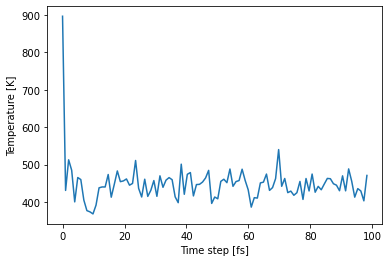

In [11]:
traj = Trajectory('hbn.traj', 'r')

time_step = np.linspace(0,(len(traj)-1)*loginterval*timestep,len(traj))
energies = [atoms.get_kinetic_energy() / (1.5 * units.kB * len(atoms)) for atoms in traj]

plt.plot(time_step, energies)
plt.xlabel('Time step [fs]')
plt.ylabel('Temperature [K]');

Choose a random ensemble of structures from the trajectory and create the frozen phonon and potential object.

In [19]:
ensemble_size = 30

random_ensemble = [traj[i] for i in np.random.choice(range(20,len(traj)), ensemble_size, replace=False)]

frozen_phonons = MDFrozenPhonons(random_ensemble)

potential = Potential(frozen_phonons, gpts=512, slice_thickness=.25)

print(f'Potential sampling: {potential.sampling}')

Potential sampling: (0.03420703125, 0.033856180629197895)


Create a scattering matrix and show the corresponding probe.

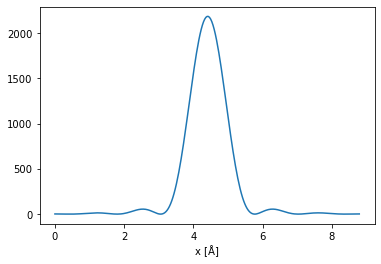

In [25]:
S = SMatrix(energy=80e3, semiangle_cutoff=20, expansion_cutoff=20, interpolation=2)

S.grid.match(potential)

S.profile().show();

Create a gridscan covering a periodic unit of the structure.

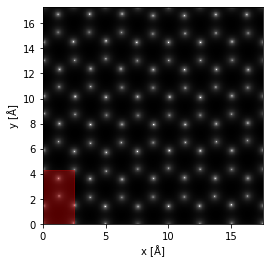

In [26]:
scan = GridScan((0,0), 
                (potential.extent[0] / repetitions[0], 
                 potential.extent[1] / repetitions[1]), 
                sampling=.1)

ax,im=potential.project().show()
scan.add_to_mpl_plot(ax)

Create the detector and start the simulation.

In [27]:
detector = FlexibleAnnularDetector()

measurement = S.scan(scan, detector, potential)

Integrate the signals to obtain both bright and dark field images.

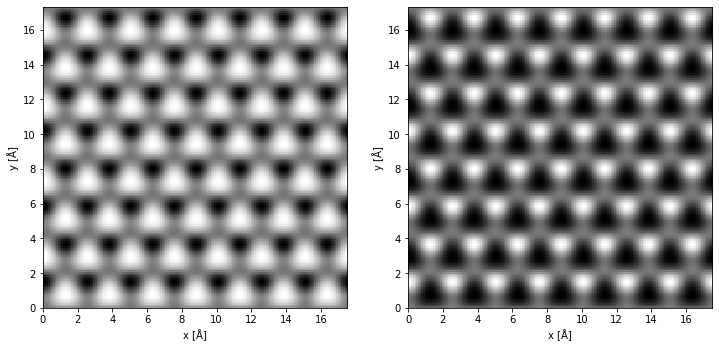

In [20]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))

measurement.integrate(0,25).tile(repetitions[:2]).show(ax=ax1)
measurement.integrate(50,150).tile(repetitions[:2]).show(ax=ax2);